# ml lab6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

### 1. read data

In [2]:
data = scipy.io.loadmat('data/ex6data1.mat')
X = data['X']

X.shape

(50, 2)

### 2. random init centroids

In [3]:
def rand_centroids(X, K):
    rand_indices = np.arange(len(X))
    np.random.shuffle(rand_indices)
    centroids = X[rand_indices][:K]
    return centroids

rand_centroids(X, 3)

array([[3.97176248, 5.40773735],
       [3.47580524, 3.63284876],
       [4.57407171, 5.39765069]])

### 3. closest centroids search

In [4]:
def find_closest_centroids(X, centroids):
    distances = np.array([np.sqrt((X.T[0] - c[0])**2 + (X.T[1] - c[1])**2) for c in centroids])
    return distances.argmin(axis=0)

### 4. centroids recompute

In [5]:
def compute_means(X, centroid_idx, K):
    centroids = []
    for k in range(K):
        t = X[centroid_idx == k]
        c = np.mean(t, axis=0) if t.size > 0 else np.zeros((X.shape[1],))
        centroids.append(c)

    return np.array(centroids)

### 5. k-means algorithm

In [6]:
def run_k_means(X, K, num_iter=10):
    centroids = rand_centroids(X, K)
    centroids_history = [centroids]
    
    for i in range(num_iter):
        centroid_idx = find_closest_centroids(X, centroids)
        centroids = compute_means(X, centroid_idx, K)
        centroids_history.append(centroids)

    return centroids, centroid_idx, centroids_history

In [7]:
def k_means_distortion(X, centroids, idx):
    K = centroids.shape[0]
    distortion = 0
    
    for i in range(K):
        distortion += np.sum((X[idx == i] - centroids[i])**2)
    
    distortion /= X.shape[0]
    return distortion

In [8]:
def find_best_k_means(X, K, num_iter=100):
    result = np.inf
    r_centroids = None
    r_idx = None
    r_history = None
    
    for i in range(num_iter):
        centroids, idx, history = run_k_means(X, K)
        d = k_means_distortion(X, centroids, idx)
        
        if d < result:
            print(f'> [{i}]: k-means improved with distortion: {d}')
            r_centroids = centroids
            r_idx = idx
            r_history = history
            result = d

    return r_centroids, r_idx, r_history

### 6. plot data with `K=3`

In [9]:
import matplotlib.cm as cm

def plot_k_means(X, K, centroid_idx, centroids_history):
    plt.figure(figsize=(15, 10))
    colors = cm.rainbow(np.linspace(0, 1, K))
    
    for k in range(K):
        plt.scatter(X[centroid_idx == k][:, 0], X[centroid_idx == k][:, 1], c=[colors[k]])

    for i in range(K):
        vals = np.array([points[i] for points in centroids_history])
        plt.plot(vals[:, 0], vals[:, 1], '-Xk', c=colors[i], markeredgecolor='black')

    plt.title(f'K-Means with K={K}, {len(centroids_history)-1} iterations')
    plt.show()

> [0]: k-means improved with distortion: 0.5927612624586158
> [4]: k-means improved with distortion: 0.5927612624586157


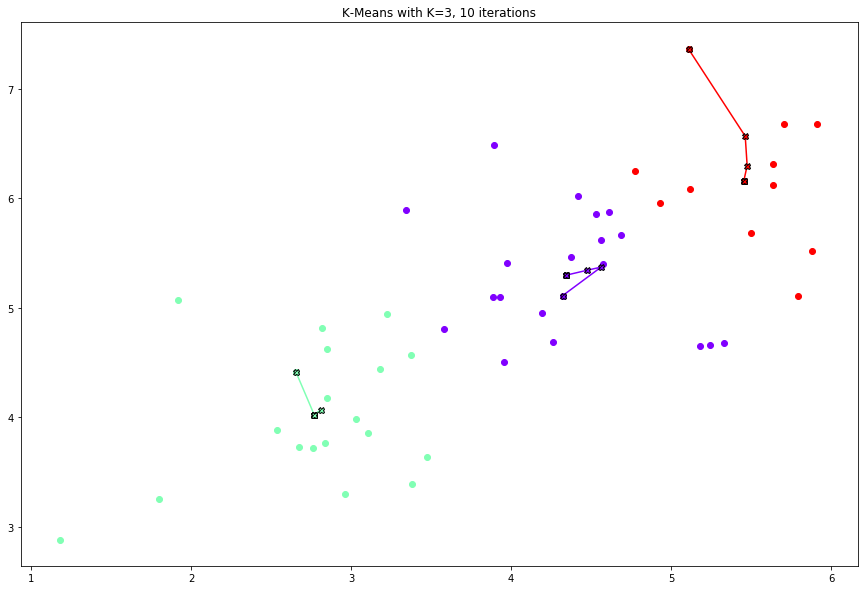

In [10]:
K = 3
centroids, idx, history = find_best_k_means(X, K)
plot_k_means(X, K, idx, history)

### 7. read `bird_small.mat` data

In [11]:
img = scipy.io.loadmat('data/bird_small.mat')
A = np.reshape(img['A'], newshape=(-1, 3))
A = A.astype('float') / 255.0

A.shape

(16384, 3)

### 8. compress image with k-means, 16 colors

In [12]:
def show_images(original, compressed):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs.flat[0].imshow(original)
    axs.flat[1].imshow(compressed)
    plt.show()

> [0]: k-means improved with distortion: 0.01506200171688582
> [8]: k-means improved with distortion: 0.014609319348327236
> [18]: k-means improved with distortion: 0.014438079802673498
> [23]: k-means improved with distortion: 0.014037904778534324
> [36]: k-means improved with distortion: 0.014002710979502245
> [95]: k-means improved with distortion: 0.013966168991687834


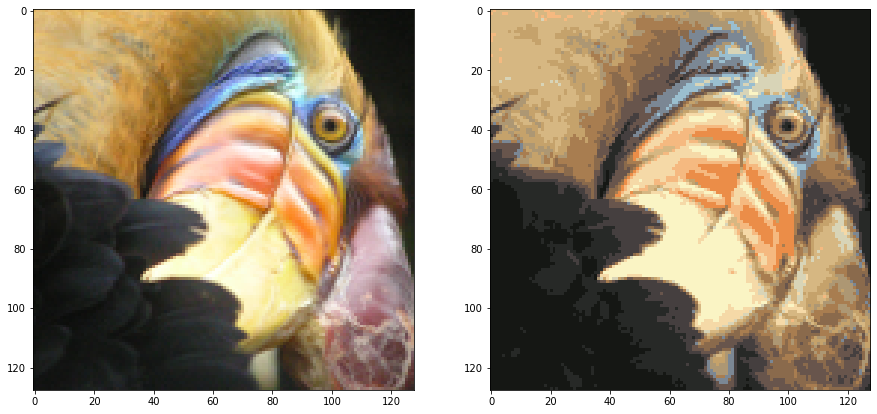

In [13]:
K = 16
centroids, idx, _ = find_best_k_means(A, K)

A_recon = centroids[idx]
A_recon = A_recon.reshape(-1, 128, 3)

show_images(img['A'], A_recon)

In [14]:
w, h = 128, 128
bits_per_pixel = 24
o_size = w * h * bits_per_pixel
print(f'Original:\t{o_size} bytes, {A.nbytes / 1024} kb')

colors = 16
comp_size = colors * bits_per_pixel + w * h * colors / 4

print(f'Compressed:\t{comp_size} bytes, {comp_size / 1024} kb, x{o_size / comp_size:.0f} times smaller')

Original:	393216 bytes, 384.0 kb
Compressed:	65920.0 bytes, 64.375 kb, x6 times smaller


### 9. test one more image

In [22]:
import matplotlib.image as mpimg

lena = mpimg.imread('data/lena.png')
lena = lena[:, :, :3]

A = np.reshape(lena, newshape=(-1, 3))
K = 16

centroids, idx, _ = find_best_k_means(A, K)
A_recon = centroids[idx]
A_recon = A_recon.reshape(-1, lena.shape[1], 3)

> [0]: k-means improved with distortion: 0.0042567076670820825
> [1]: k-means improved with distortion: 0.004147654079133645
> [6]: k-means improved with distortion: 0.0041380758048035204
> [7]: k-means improved with distortion: 0.004073591306223534
> [11]: k-means improved with distortion: 0.004045207242597826
> [15]: k-means improved with distortion: 0.004021155495138373
> [71]: k-means improved with distortion: 0.00396623823326081


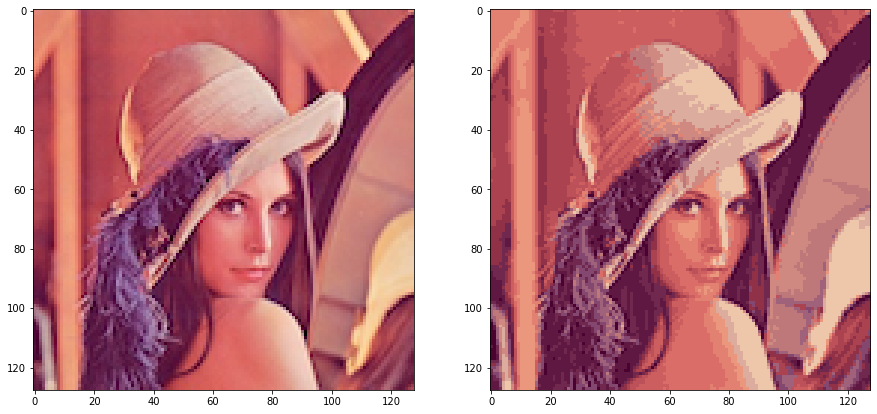

In [23]:
show_images(lena, A_recon)

### 10. hierarchical clustering algorithm

In [24]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=K).fit(A)
idx = clustering.labels_
centroids = compute_means(A, idx, K)
A_recon = centroids[idx]
A_recon = A_recon.reshape(-1, data.shape[1], 3)

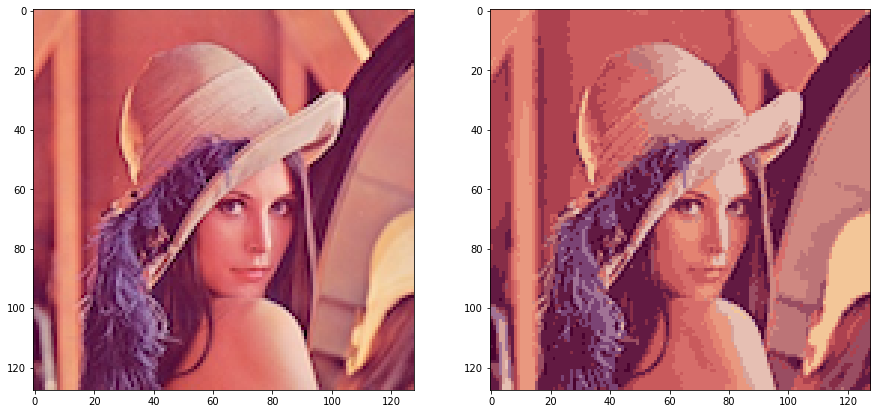

In [25]:
show_images(lena, A_recon)

> На глаз результат сжатия методом `K-means` и иерахической кластеризации используя `scipy` реализацию `AgglomerativeClustering` получился одинаковым

### 12. conclusions

В данной работе рассмотрен метод кластеризации `K-means`, произведено сжатие изображения до 16 цветов